<a href="https://colab.research.google.com/github/samuel0922/my_ex/blob/main/%5BEX_14%5DCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [EX_14]CIFAR10
###개요
*  앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.

###목차
* STEP 1. 환경 설정
* STEP 2. 데이터 준비 및 전처리
* STEP 3. 모델 준비
* STEP 4. 학습
* STEP 5. 시각화
* STEP 6. 성능개선

* 루브릭
* 회고

## STEP 1. 환경설정

In [ ]:
# 라이브러리 임포트

%%capture
!install tensorflow

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## STEP 1. 데이터 로딩 및 전처리

In [ ]:
# 파이썬 언더스코어(_) 처리 => 데이터셋에서 불필요한 것을 사용하지 않게 함 

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [ ]:
# 데이터 확인

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
# 정규화 : 각 픽셀을 -1.1로 정규화 <- 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줌

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
# 데이터 형태 확인

train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


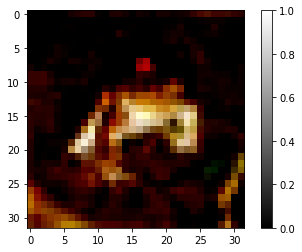

In [ ]:
# 실제 데이터 확인

plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

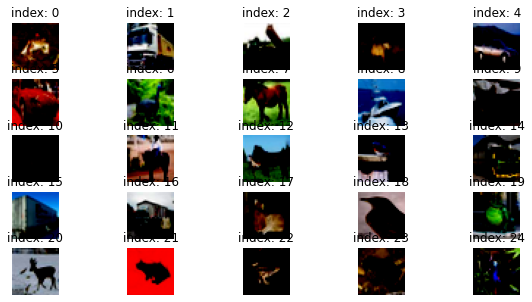

In [ ]:
# 10개 이미지 확인

plt.figure(figsize=(10, 5))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## STEP 3. 모델 구현 using Keras Sequential API

In [ ]:
# 미니배치 설정

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### S3-1. 생성모델 구현


In [ ]:
# 생성모델 정의

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # 1st: Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2nd: Reshape layer
    model.add(layers.Reshape((4, 4, 1024)))

    # 3rd: Conv2DTranspose layer => 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) # => 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화 함
    model.add(layers.LeakyReLU())

    # 4th: Conv2DTranspose layer => 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) # => 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화 함
    model.add(layers.LeakyReLU())

     # 5th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 6th: Conv2DTranspose layer => tanh :: 앞에서 정규화 시켜준 데이터셋과 일치시키기 위함
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) 

    return model

In [ ]:
# 모델 형상 확인

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107200  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

In [ ]:
# 노이즈 벡터 생성 <- 가우시안 분포에서 뽑아낸 랜덤 벡터

noise = tf.random.normal([1, 100])

In [ ]:
# 간단한 이미지 생성 테스트 

# Batch Normalization 레이어는 학습과 추론의 행동이 다름. 
# 학습이 아니므로 training=False로 설정해 줌

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

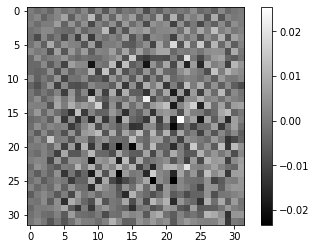

In [ ]:
# 시각화를 통한 이미지 확인

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### S3-2. 판별모델 구현


In [ ]:
# 판별 모델 정의 => 생성자 모델과 대칭되도록 함

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # 1st: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())

    # 2nd: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 3rd: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    # 4th: Flatten Layer => 3차원 이미지를 1차원으로 펴서 7x7x128=6272 (1, 6272)형상의 벡터로 변환
    model.add(layers.Flatten())

    # 5rd: Dense Layer
    model.add(layers.Dense(4*4*1024, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 6th: Dense Layer => 단 하나의 값으로 출력
    model.add(layers.Dense(1))

    return model

In [ ]:
# 모델 형상 확인

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       9728      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         819456    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         3277312   
                                                      

In [ ]:
# 테스트

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00033489]], dtype=float32)>

## STEP 4. 모델 학습

### S4-1. 손실함수 정의

In [ ]:
# 손실함수 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# fake_output과 real_output을 각각 1 또는 0에 비교 하기 위해 0벡터 만들어줌

vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [ ]:
# 생성자 손실 함수 정의 => fake_output이 1에 가까워지는 것이 목표이므로
# tf.ones_like와 교차 엔트로피값을 계산해 줌

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# 판별자 손실 함수 정으 => real_output이 1에 가까워지는 것이 목표이므로
# 두 가지 loss를 모두 계산함
# real_output은 1 벡터, fake_output은 0벡터와 각각 비교해 줌
# 최종 discriminator_loss 값은 이 둘을 더한 값이 됨

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### S4-2. Accuracy 설계
> * 판별자의 정확도는 기존의 신경망 모델의 정확도와 의미가 다름
> * real_output과 fake_output에 대해 1.0에 가깝게 정확하게 판별한다면 => fake와 real이 쉽게 구분된다는 의미
> * 그러므로 초반에 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적


In [ ]:
# 판별자 정확도 계산

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### S4-3. 최적화함수 Optimizer 설계
> * 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer도 따로 만들어줘야 함
> * lr(learing rate, 학습률) : HYPER PARAMETER

In [ ]:
# 생성자 optimizer 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 구분자 optimizer 정의
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### S4-4. 학습 확인용 샘플 생성
> * 한 번에 16장씩 생성
> * 매번 같은 노이즈 생성을 위해 고정된 seed로 노이즈 생성<br>

=> 100차원 노이즈 초 16개, (16, 100) 형상의 벡터

In [ ]:
# 학습상황 확인을 위한 샘플 확인 : 한 번에 16장 생성

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### S4-5. 훈련 코드 설계
< 데코레이터 @tf.function >
> * 하나의 미니 배치 당 진행할 train_step 함수 정의 -> 데코레이터(@tf.function) 이용=>tf 1.x 이전 버전과 달리 session 사용 않고도 데코레이터가 내부적으로 처리
> * @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환


#### train_step : 한 단게씩 학습
1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음<br>
2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함<br>
3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기<br>
4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성<br>
5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력<br>
6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산<br>
7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산<br>
8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산<br>
9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신<br>
10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [ ]:
# train_step 정의 : 한 단계씩 학습

@tf.function  # 데코레이터
def train_step(images):  #(1) 입력데이터 : Real Image 역할 images 한 세트 입력
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈를 batch_size만큼 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
# 학습현황 확인을 위한 샘플 만드는 함수 정의

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format('/content/drive/MyDrive', epoch, it))

    plt.show()

In [ ]:
# 시각화 설계 : 

# train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 
# history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format('/content/drive/MyDrive', epoch))
    plt.show()

In [ ]:
# checkpoint 설계 : 정기적으로 모델을 저장

# tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 
# 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
# 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적

# checkpoint에는 학습환경과 학슴한 내용 즉, optimizer와 생성자, 판별자를 모두 넣어 저장
# 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장

checkpoint_dir = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# 학습을 위해 설계한 모듈을 하나의 함수로 합쳐줌

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### S4-6. 모델 학습

In [ ]:
# 하이퍼 파라미터 설정

save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

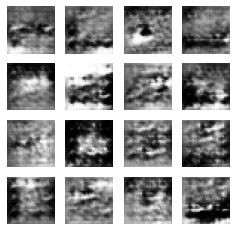

Time for training : 3909 sec


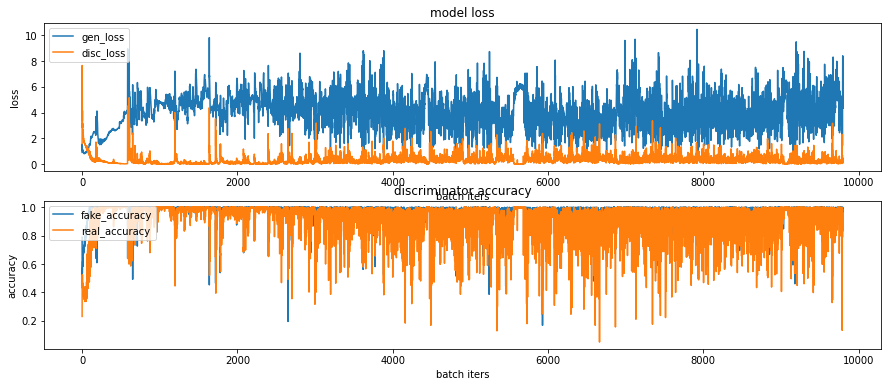

CPU times: user 1h 2min 30s, sys: 57.4 s, total: 1h 3min 27s
Wall time: 1h 5min 10s


In [ ]:
# 학습 시작

%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## STEP 5. 학습과정 시각화

In [ ]:
anim_file = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format('/content/drive/MyDrive'))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw------- 1 root root 1349635 Jun 23 13:19 /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## STEP 6. 성능개선 : Optimizer 설정 변경
* 생성자 optimizer : 1e-4 -> 2e-4
* 구분자 optimizer : 1e-4 -> 2e-4

In [ ]:
# 생성자 optimizer 정의
generator_optimizer = tf.keras.optimizers.Adam(2e-4)

# 구분자 optimizer 정의
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

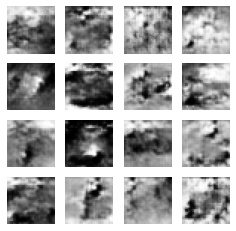

Time for training : 3895 sec


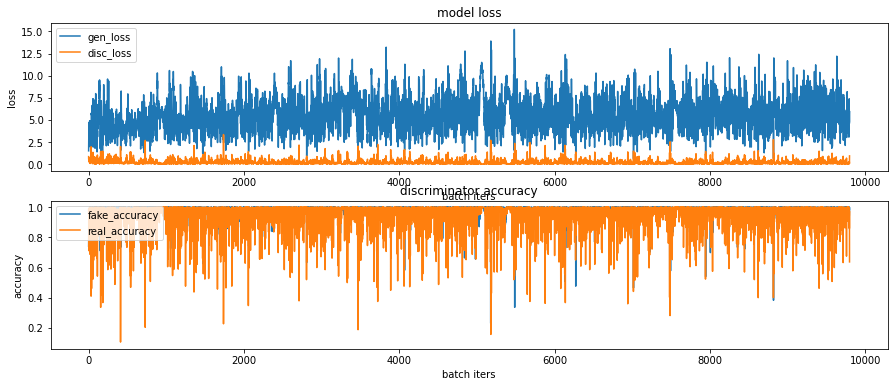

CPU times: user 1h 3min 1s, sys: 56.8 s, total: 1h 3min 57s
Wall time: 1h 4min 57s


In [ ]:
# 학습 시작

%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file2 = '/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file2, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format('/content/drive/MyDrive'))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif

-rw------- 1 root root 1333856 Jun 23 14:26 /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif


## [ 루브릭 ]
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성
* => 생성된 이미지는 성능개선을 마친 후에도 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하지는 못하였음. 좀 더 충분한 학습이 필요할 것으로 보이지만 제출 시한에 맞춰 일단 제출하고 밤 사이 칼라이미지로 바꾸고 훈련 시간을 늘려 시도해 보려고 함.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증
* => gif를 통해 생성이미지 품질이 서서히 향상되는 것은 확인할 수 있었지만, fake accuracy가 추세적으로 0.5를 향해 매우 완만하게 나마 하향하고 있는 것은 확인하였음.
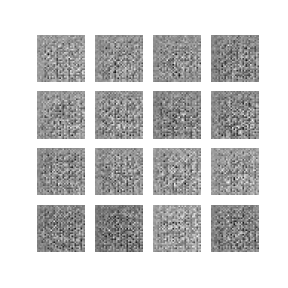

3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용
* => GAN 모델의 성능 개선을 위한 다양한 방법에 대해 조사해 본 결과, 옵티마이저의 설정값을 변경하는 것이 다른 방법보다 더 크게 향상되는 것으로 되어 있어 이를 적용해 보았으나, 적용하지 않은 기본 모델에 비해서 현저하게 향상된 것을 확인하진 못하였음.

## [ 회고 ]

* GAN모델은 판별모델과 생성모델이 서로 경쟁하면서 궁극적으로 생성모델의 성능을 향상시킨다는 발상이 신박하였음.

* 그렇지만 GAN 모델은 그간에 학습하였던 CNN에 대한 지식을 바탕으로 볼 때, CNN으로 추출된 특성맵을 활용해 새로운 이미지를 생성한다는 것이 개념적으로는 수긍이 되는 모델임.

* 다만, 실제 구현에 필요한 내용에 대해서는 간단치 않아 이해하는데 어려움이 있었음. 

* 흥미로운 모델이라 좀 더 학습을 통해 이해를 높인다면 활용도가 클 것으로 기대됨. 




